# Data Preperation

## Prepare the geo data for the GIS analysis

In [109]:
import geopandas as gpd
import pandas as pd

1. Load us county geo data
2. Load the commuting zone indexing data, which is a xlsx file, contains the county to commuting zone mapping
3. Join the commuting zone data to the county geo data
4. Group the county geo data by commuting zone, and calculate the centroid of each commuting zone
5. Save the commuting zone geo data to a geojson file

In [110]:
# read in the shapefile of the us conties
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    us_counties = json.load(response)

us_counties["features"][0]

{'type': 'Feature',
 'properties': {'GEO_ID': '0500000US01001',
  'STATE': '01',
  'COUNTY': '001',
  'NAME': 'Autauga',
  'LSAD': 'County',
  'CENSUSAREA': 594.436},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-86.496774, 32.344437],
    [-86.717897, 32.402814],
    [-86.814912, 32.340803],
    [-86.890581, 32.502974],
    [-86.917595, 32.664169],
    [-86.71339, 32.661732],
    [-86.714219, 32.705694],
    [-86.413116, 32.707386],
    [-86.411172, 32.409937],
    [-86.496774, 32.344437]]]},
 'id': '01001'}

In [111]:
# create a geodataframe of us counties from the json file, including all of the properties
us_counties_gdf = gpd.GeoDataFrame.from_features(us_counties["features"])

In [112]:
# seperate the last 5 digits of the GEO_ID column to get the fips code
us_counties_gdf['FIPS'] = us_counties_gdf['GEO_ID'].str[-5:]
us_counties_gdf.head()

geometry          GEO_ID STATE   
0  POLYGON ((-86.49677 32.34444, -86.71790 32.402...  0500000US01001    01  \
1  POLYGON ((-86.57780 33.76532, -86.75914 33.840...  0500000US01009    01   
2  POLYGON ((-85.18413 32.87053, -85.12342 32.772...  0500000US01017    01   
3  POLYGON ((-86.51734 33.02057, -86.51596 32.929...  0500000US01021    01   
4  POLYGON ((-88.13999 34.58170, -88.13925 34.587...  0500000US01033    01   

  COUNTY      NAME    LSAD  CENSUSAREA   FIPS  
0    001   Autauga  County     594.436  01001  
1    009    Blount  County     644.776  01009  
2    017  Chambers  County     596.531  01017  
3    021   Chilton  County     692.854  01021  
4    033   Colbert  County     592.619  01033

In [113]:
# convert the fips to int
us_counties_gdf['FIPS'] = us_counties_gdf['FIPS'].astype(int)
# read in the commuting zone data, which is a excel file
commuting_zones = pd.read_excel('../data/commuting_zones/cz00_eqv_v1.xls')
commuting_zones.head(2)

FIPS  Commuting Zone ID, 2000  Commuting Zone ID, 1990   
0  1001                       60                  11101.0  \
1  1003                      254                  11001.0   

   Commuting Zone ID, 1980     County Name   
0                  28101.0  Autauga County  \
1                  28201.0  Baldwin County   

                             Metropolitan Area, 2003  County Population 2000   
0       Montgomery, AL Metropolitan Statistical Area                   43671  \
1  Daphne-Fairhope, AL Micropolitan Statistical Area                  140415   

   Commuting Zone Population 2000  
0                        448828.0  
1                        558355.0

In [114]:
# merge the commuting zone data with the us_counties data, each commuting zone contains multiple counties, so we use the left join, and the key is the commuting zone id

commuting_zones_gdf = us_counties_gdf.merge(commuting_zones, left_on='FIPS', right_on='FIPS', how='left')

commuting_zones_gdf.head(2)

geometry          GEO_ID STATE   
0  POLYGON ((-86.49677 32.34444, -86.71790 32.402...  0500000US01001    01  \
1  POLYGON ((-86.57780 33.76532, -86.75914 33.840...  0500000US01009    01   

  COUNTY     NAME    LSAD  CENSUSAREA  FIPS  Commuting Zone ID, 2000   
0    001  Autauga  County     594.436  1001                     60.0  \
1    009   Blount  County     644.776  1009                     21.0   

   Commuting Zone ID, 1990  Commuting Zone ID, 1980     County Name   
0                  11101.0                  28101.0  Autauga County  \
1                  10700.0                  28401.0   Blount County   

                             Metropolitan Area, 2003  County Population 2000   
0       Montgomery, AL Metropolitan Statistical Area                 43671.0  \
1  Birmingham-Hoover, AL Metropolitan Statistical...                 51024.0   

   Commuting Zone Population 2000  
0                        448828.0  
1                        981525.0

In [115]:
#dissolve the counties into commuting zones, use the Commuting Zone ID, 1990 as the key
commuting_zones_gdf = commuting_zones_gdf.dissolve(by='Commuting Zone ID, 1990')

commuting_zones_gdf.head(2)

geometry   
Commuting Zone ID, 1990                                                      
100.0                    POLYGON ((-82.50586 35.97834, -82.50707 35.977...  \
200.0                    POLYGON ((-83.77988 35.86018, -83.78444 35.868...   

                                 GEO_ID STATE COUNTY        NAME    LSAD   
Commuting Zone ID, 1990                                                    
100.0                    0500000US47179    47    179  Washington  County  \
200.0                    0500000US47057    47    057    Grainger  County   

                         CENSUSAREA   FIPS  Commuting Zone ID, 2000   
Commuting Zone ID, 1990                                               
100.0                       326.465  47179                    167.0  \
200.0                       280.600  47057                    328.0   

                         Commuting Zone ID, 1980        County Name   
Commuting Zone ID, 1990                                               
100.0                                    36201.0  Washington County  \
200.0                                    36101.0    Grainger County   

                                                Metropolitan Area, 2003   
Commuting Zone ID, 1990                                                   
100.0                    Johnson City, TN Metropolitan Statistical Area  \
200.0                      Morristown, TN Metropolitan Statistical Area   

                         County Population 2000   
Commuting Zone ID, 1990                           
100.0                                  107198.0  \
200.0                                   20659.0   

                         Commuting Zone Population 2000  
Commuting Zone ID, 1990                                  
100.0                                          576081.0  
200.0                                          234602.0

In [116]:
#simplify cz shape datasets to only key information
# This code selects only the columns that are relevant to the analysis from the original dataset, and creates a new geodataframe with only those columns.

simple_cz = gpd.GeoDataFrame(commuting_zones_gdf, columns=['geometry',
                                                 'Commuting Zone Population 2000',
                                                 'Metropolitan Area, 2003'])
# reset the index of the dataframe to make the Commuting Zone ID, 1990 a column
simple_cz = simple_cz.reset_index()

simple_cz.head(2)

Commuting Zone ID, 1990                                           geometry   
0                    100.0  POLYGON ((-82.50586 35.97834, -82.50707 35.977...  \
1                    200.0  POLYGON ((-83.77988 35.86018, -83.78444 35.868...   

   Commuting Zone Population 2000   
0                        576081.0  \
1                        234602.0   

                          Metropolitan Area, 2003  
0  Johnson City, TN Metropolitan Statistical Area  
1    Morristown, TN Metropolitan Statistical Area

In [117]:
# plot the simple cz map with plotly express choropleth map, the color is based on the commuting zone population in 2000
import plotly.express as px

fig = px.choropleth(simple_cz, geojson=simple_cz.geometry, locations=simple_cz.index, color="Commuting Zone Population 2000",
                            color_continuous_scale="Viridis",
                            range_color=(0, 1000000),
                            scope="usa",
                            labels={'Commuting Zone Population 2000':'Population'},
                            hover_name="Commuting Zone ID, 1990",
                            hover_data=["Commuting Zone Population 2000"],
                            )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [118]:
# save the simple_cz dataframe to a geojson file
simple_cz.to_file('../data/commuting_zones/cz_shape_1990_pop2000.geojson', driver='GeoJSON')

## Prepare the migration data

There are 3 migration data files: 

- od_pooled.csv – Dataset contains count and fractions of people who move between each origin and destination (OD) commuting zone pair. These data are unique at the OD level. The variable pool takes the value “pooled”.
- od_race.csv – Dataset contains count and fractions of people who move between each OD commuting zone pair separately by race/ethnicity. These data are unique at the OD x race level. The variable pool takes the values “Asian”, “Black”, “Hispanic”, “White”, and “Other”. Note that “Other” includes not only other races but also people who are not linked to the Decennial Census or ACS
- od_inc.csv – Dataset contains count and fractions of people who move between each origin and destination commuting zone pair separately by parental income quintile. These data are unique at the OD x income quintile level. The variable pool takes the values “Q1” (poorest parental income quintile), …, “Q5” (richest parental income quintile).

## OD Pooled Data

In [119]:
# read in the data from the dataset folder and create a dataframe
df_pooled = pd.read_csv('../data/raw_dataset/od_pooled.csv', sep=',')
df_pooled.head()

o_cz   o_cz_name o_state_name  d_cz     d_cz_name d_state_name      n   
0   6502   Cleveland    Tennessee   100  Johnson City    Tennessee  127.0  \
1  34108      Kodiak       Alaska   100  Johnson City    Tennessee    0.0   
2  10302      Dothan      Alabama   100  Johnson City    Tennessee   16.0   
3   5201  New Albany  Mississippi   100  Johnson City    Tennessee    1.0   
4  29201    Hiawatha       Kansas   100  Johnson City    Tennessee    0.0   

   n_tot_o  n_tot_d    pool    pr_d_o    pr_o_d  
0    22148    56915  pooled  0.005734  0.002231  
1     1702    56915  pooled  0.000000  0.000000  
2    26182    56915  pooled  0.000611  0.000281  
3     6530    56915  pooled  0.000153  0.000018  
4     2794    56915  pooled  0.000000  0.000000

In [120]:
# create a new dataframe grouped by the o_cz, with o_cz_name and o_state_name as the columns, and the sum of n as the values
df_o = df_pooled.groupby(['o_cz', 'o_cz_name', 'o_state_name']).sum()['n'].reset_index()
df_o.head()

o_cz       o_cz_name    o_state_name        n
0   100    Johnson City       Tennessee  57198.0
1   200      Morristown       Tennessee  24922.0
2   301  Middlesborough       Tennessee   6539.0
3   302       Knoxville       Tennessee  76167.0
4   401   Winston-Salem  North Carolina  53108.0

In [121]:
# create a new dataframe grouped by the d_cz, with d_cz_name and d_state_name as the columns, and the first n_tot_d value as the value
df_d = df_pooled.groupby(['d_cz', 'd_cz_name', 'd_state_name']).first()['n_tot_d'].reset_index()
df_d.head()

d_cz       d_cz_name    d_state_name  n_tot_d
0   100    Johnson City       Tennessee    56915
1   200      Morristown       Tennessee    24188
2   301  Middlesborough       Tennessee     6035
3   302       Knoxville       Tennessee    84432
4   401   Winston-Salem  North Carolina    52381

In [122]:
# merge the geometry from simple_cz with the df_o dataframe, the key is the o_cz
df_o = simple_cz.merge(df_o, left_on='Commuting Zone ID, 1990', right_on='o_cz', how='left')
df_o.head(2)

Commuting Zone ID, 1990                                           geometry   
0                    100.0  POLYGON ((-82.50586 35.97834, -82.50707 35.977...  \
1                    200.0  POLYGON ((-83.77988 35.86018, -83.78444 35.868...   

   Commuting Zone Population 2000   
0                        576081.0  \
1                        234602.0   

                          Metropolitan Area, 2003  o_cz     o_cz_name   
0  Johnson City, TN Metropolitan Statistical Area   100  Johnson City  \
1    Morristown, TN Metropolitan Statistical Area   200    Morristown   

  o_state_name        n  
0    Tennessee  57198.0  
1    Tennessee  24922.0

In [123]:
# save the df_o dataframe to a geojson file
df_o.to_file('../data/pooled data/df_o.geojson', driver='GeoJSON')

In [124]:
# merge the geometry from simple_cz with the df_d dataframe, the key is the d_cz
df_d = simple_cz.merge(df_d, left_on='Commuting Zone ID, 1990', right_on='d_cz', how='left')
df_d.head(2)

Commuting Zone ID, 1990                                           geometry   
0                    100.0  POLYGON ((-82.50586 35.97834, -82.50707 35.977...  \
1                    200.0  POLYGON ((-83.77988 35.86018, -83.78444 35.868...   

   Commuting Zone Population 2000   
0                        576081.0  \
1                        234602.0   

                          Metropolitan Area, 2003  d_cz     d_cz_name   
0  Johnson City, TN Metropolitan Statistical Area   100  Johnson City  \
1    Morristown, TN Metropolitan Statistical Area   200    Morristown   

  d_state_name  n_tot_d  
0    Tennessee    56915  
1    Tennessee    24188

In [125]:
# save the df_d dataframe to a geojson file
df_d.to_file('../data/pooled data/df_d.geojson', driver='GeoJSON')

In [126]:
# create a new dataframe from df with o_cz, d_cz, and pr_d_o and pr_o_d as the columns
df_od = df_pooled[['o_cz', 'd_cz', 'pr_d_o', 'pr_o_d']]
df_od = df_od.reset_index()
df_od.head()

index   o_cz  d_cz    pr_d_o    pr_o_d
0      0   6502   100  0.005734  0.002231
1      1  34108   100  0.000000  0.000000
2      2  10302   100  0.000611  0.000281
3      3   5201   100  0.000153  0.000018
4      4  29201   100  0.000000  0.000000

In [127]:
# save the df_od dataframe to a csv file
df_od.to_csv('../data/pooled data/df_od.csv')

In [128]:
# create a dataframe of CZs, with the CZ ID as the index, and calcualte the centroid of each CZ.
cz_centroids = pd.DataFrame(simple_cz.set_index('Commuting Zone ID, 1990').centroid)
cz_centroids = cz_centroids.reset_index()
# rename columns to cz_id and centroid
cz_centroids.columns = ['cz_id', 'centroid']

In [129]:
cz_centroids.head()

cz_id                    centroid
0  100.0  POINT (-82.38031 36.48858)
1  200.0  POINT (-83.38231 35.98767)
2  301.0  POINT (-83.56767 36.57987)
3  302.0  POINT (-84.19294 36.02226)
4  401.0  POINT (-80.47601 36.24673)

In [130]:
# join the centroid dataframe with the df_od, matching the o_cz and d_cz columns
df_od = df_od.merge(cz_centroids, left_on='o_cz', right_on='cz_id', how='left')
df_od = df_od.merge(cz_centroids, left_on='d_cz', right_on='cz_id', how='left')

df_od.head()

index   o_cz  d_cz    pr_d_o    pr_o_d  cz_id_x   
0      0   6502   100  0.005734  0.002231   6502.0  \
1      1  34108   100  0.000000  0.000000  34108.0   
2      2  10302   100  0.000611  0.000281  10302.0   
3      3   5201   100  0.000153  0.000018   5201.0   
4      4  29201   100  0.000000  0.000000  29201.0   

                    centroid_x  cz_id_y                  centroid_y  
0   POINT (-84.54392 35.33149)    100.0  POINT (-82.38031 36.48858)  
1  POINT (-153.78788 57.66681)    100.0  POINT (-82.38031 36.48858)  
2   POINT (-85.61058 31.32015)    100.0  POINT (-82.38031 36.48858)  
3   POINT (-89.02858 34.69632)    100.0  POINT (-82.38031 36.48858)  
4   POINT (-95.81466 39.80252)    100.0  POINT (-82.38031 36.48858)

In [131]:
# save the df_od dataframe to a csv file named df_od_centroids.csv
df_od.to_csv('../data/pooled data/df_od_centroids.csv')

In [132]:
# separate centroid into two columns, one for the x coordinate and one for the y coordinate
df_od['o_x'] = df_od['centroid_x'].apply(lambda p: p.x)
df_od['o_y'] = df_od['centroid_x'].apply(lambda p: p.y)
df_od['d_x'] = df_od['centroid_y'].apply(lambda p: p.x)
df_od['d_y'] = df_od['centroid_y'].apply(lambda p: p.y)

# remove centroid columns, and rename the columns to o_cz, d_cz, pr_d_o, pr_o_d, o_x, o_y, d_x, d_y
df_od = df_od[['o_cz', 'd_cz', 'pr_d_o', 'pr_o_d', 'o_x', 'o_y', 'd_x', 'd_y']]
df_od.head()

o_cz  d_cz    pr_d_o    pr_o_d         o_x        o_y        d_x   
0   6502   100  0.005734  0.002231  -84.543924  35.331492 -82.380308  \
1  34108   100  0.000000  0.000000 -153.787883  57.666807 -82.380308   
2  10302   100  0.000611  0.000281  -85.610582  31.320145 -82.380308   
3   5201   100  0.000153  0.000018  -89.028583  34.696322 -82.380308   
4  29201   100  0.000000  0.000000  -95.814661  39.802520 -82.380308   

         d_y  
0  36.488581  
1  36.488581  
2  36.488581  
3  36.488581  
4  36.488581

In [133]:
# save df_od to a csv file named df_od_xy.csv
df_od.to_csv('../data/pooled data/df_od_xy.csv')

## Aggregate the OD Pooled Data to Commuting Zone Level

In [134]:
# calculate the distance between the origin and destination CZs in miles
import math

def distance(x1, y1, x2, y2):
    return math.sqrt((x2-x1)**2 + (y2-y1)**2)

df_od['distance'] = df_od.apply(lambda row: distance(row['o_x'], row['o_y'], row['d_x'], row['d_y']), axis=1)

df_od.head()

o_cz  d_cz    pr_d_o    pr_o_d         o_x        o_y        d_x   
0   6502   100  0.005734  0.002231  -84.543924  35.331492 -82.380308  \
1  34108   100  0.000000  0.000000 -153.787883  57.666807 -82.380308   
2  10302   100  0.000611  0.000281  -85.610582  31.320145 -82.380308   
3   5201   100  0.000153  0.000018  -89.028583  34.696322 -82.380308   
4  29201   100  0.000000  0.000000  -95.814661  39.802520 -82.380308   

         d_y   distance  
0  36.488581   2.453587  
1  36.488581  74.481938  
2  36.488581   6.094867  
3  36.488581   6.885619  
4  36.488581  13.837053

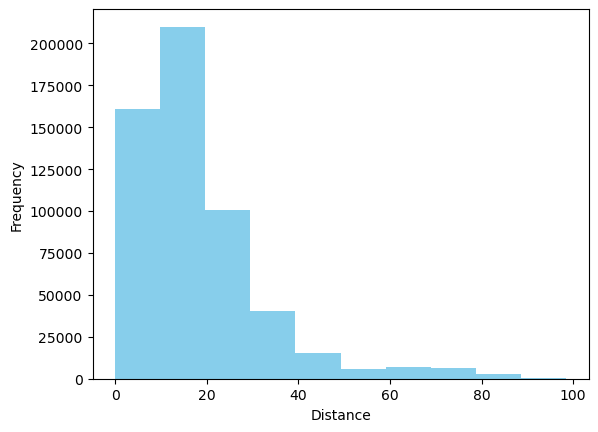

In [135]:
# plot the distance distribution, color set to skyblue, x axis is distance, y axis is frequency
import matplotlib.pyplot as plt
plt.hist(df_od['distance'], color='skyblue')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

In [136]:
# subset df_poolded to only rows where o_cz and d_cz are the same
df_self = df_pooled[df_pooled['o_cz'] == df_pooled['d_cz']]
df_self.head()

o_cz       o_cz_name    o_state_name  d_cz       d_cz_name   
170    100    Johnson City       Tennessee   100    Johnson City  \
1362   200      Morristown       Tennessee   200      Morristown   
2166   301  Middlesborough       Tennessee   301  Middlesborough   
2484   302       Knoxville       Tennessee   302       Knoxville   
3232   401   Winston-Salem  North Carolina   401   Winston-Salem   

        d_state_name        n  n_tot_o  n_tot_d    pool    pr_d_o    pr_o_d  
170        Tennessee  42829.0    57198    56915  pooled  0.748785  0.752508  
1362       Tennessee  16023.0    24922    24188  pooled  0.642926  0.662436  
2166       Tennessee   4207.0     6539     6035  pooled  0.643371  0.697100  
2484       Tennessee  55022.0    76167    84432  pooled  0.722386  0.651672  
3232  North Carolina  33790.0    53108    52381  pooled  0.636251  0.645081

In [137]:
# calculate the net migration for each CZ, n_tot_d - n_tot_o
df_self['net_migration'] = df_self['n_tot_d'] - df_self['n_tot_o']
# calculate the new moved in population for each CZ, n_tot_d - n
df_self['new_moved_in'] = df_self['n_tot_d'] - df_self['n']
# calculate the local moved out population for each CZ, n_tot_o - n
df_self['local_moved_out'] = df_self['n_tot_o'] - df_self['n']

df_self.head()

C:\Users\chenj\AppData\Local\Temp\ipykernel_33612\3770343339.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\chenj\AppData\Local\Temp\ipykernel_33612\3770343339.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\chenj\AppData\Local\Temp\ipykernel_33612\3770343339.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

o_cz       o_cz_name    o_state_name  d_cz       d_cz_name   
170    100    Johnson City       Tennessee   100    Johnson City  \
1362   200      Morristown       Tennessee   200      Morristown   
2166   301  Middlesborough       Tennessee   301  Middlesborough   
2484   302       Knoxville       Tennessee   302       Knoxville   
3232   401   Winston-Salem  North Carolina   401   Winston-Salem   

        d_state_name        n  n_tot_o  n_tot_d    pool    pr_d_o    pr_o_d   
170        Tennessee  42829.0    57198    56915  pooled  0.748785  0.752508  \
1362       Tennessee  16023.0    24922    24188  pooled  0.642926  0.662436   
2166       Tennessee   4207.0     6539     6035  pooled  0.643371  0.697100   
2484       Tennessee  55022.0    76167    84432  pooled  0.722386  0.651672   
3232  North Carolina  33790.0    53108    52381  pooled  0.636251  0.645081   

      net_migration  new_moved_in  local_moved_out  
170            -283       14086.0          14369.0  
1362           -734        8165.0           8899.0  
2166           -504        1828.0           2332.0  
2484           8265       29410.0          21145.0  
3232           -727       18591.0          19318.0

In [138]:
# save the df_self dataframe to a csv file named df_self.csv
df_self.to_csv('../data/pooled data/df_self.csv')

### Load Counties Population Data 2018

In [177]:
# load in conties population data 2018
df_counties_2018 = pd.read_csv('../data/pooled data/co-est2018-alldata.csv', encoding='latin-1')

In [140]:
da_counties_2018 = df_counties_2018[['STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'POPESTIMATE2018']]
da_counties_2018.head()

STATE  COUNTY   STNAME         CTYNAME  POPESTIMATE2018
0      1       0  Alabama         Alabama          4887871
1      1       1  Alabama  Autauga County            55601
2      1       3  Alabama  Baldwin County           218022
3      1       5  Alabama  Barbour County            24881
4      1       7  Alabama     Bibb County            22400

In [141]:
# remove the word county from the county name column
da_counties_2018['CTYNAME'] = da_counties_2018['CTYNAME'].str.replace(' County', '')
da_counties_2018.head()

C:\Users\chenj\AppData\Local\Temp\ipykernel_33612\2253037228.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



STATE  COUNTY   STNAME  CTYNAME  POPESTIMATE2018
0      1       0  Alabama  Alabama          4887871
1      1       1  Alabama  Autauga            55601
2      1       3  Alabama  Baldwin           218022
3      1       5  Alabama  Barbour            24881
4      1       7  Alabama     Bibb            22400

In [184]:
commuting_zones1 = pd.read_excel('../data/commuting_zones/cz00_eqv_v1.xls')
commuting_zones1.head(2)


FIPS  Commuting Zone ID, 2000  Commuting Zone ID, 1990   
0  1001                       60                  11101.0  \
1  1003                      254                  11001.0   

   Commuting Zone ID, 1980     County Name   
0                  28101.0  Autauga County  \
1                  28201.0  Baldwin County   

                             Metropolitan Area, 2003  County Population 2000   
0       Montgomery, AL Metropolitan Statistical Area                   43671  \
1  Daphne-Fairhope, AL Micropolitan Statistical Area                  140415   

   Commuting Zone Population 2000  
0                        448828.0  
1                        558355.0

In [185]:
#sum counties population
commuting_zones1['County Population 2000'].sum()


281421906